In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
oscar_movies = pd.read_csv("./oscar_movies.csv")
oscar_movies.Runtime = oscar_movies.Runtime.str.split(" ").str[0].fillna(0).astype(int)

#### In our DataFrame, we have 2 columns, Genre and tag that are lists represented as strings. In order to do any predictions with using these variables as features, we must use a binarizer to dummify the variables. We then concatenate them with our main DataFrame.

In [3]:
binarizer = MultiLabelBinarizer()
genres = pd.DataFrame(
    binarizer.fit_transform(oscar_movies["Genre"].astype(str).str.replace(" ", "").str.split(",")),
    columns=binarizer.classes_
)
binarizer = MultiLabelBinarizer()
tags = pd.DataFrame(
    binarizer.fit_transform(oscar_movies["tag"].astype(str).str.replace(" ", "").str.split(",")),
    columns=binarizer.classes_
)

In [4]:
movies_dummies = pd.concat([oscar_movies, genres], axis=1)
movies_dummies = pd.concat([movies_dummies, tags], axis=1)

#### Here are the functions we use to create models

In [5]:
def get_f1_score(k):
    X_dict = movies_dummies[features].to_dict(orient="records")
    y = movies_dummies["winner"]
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    return cross_val_score(pipeline, X_dict, y, 
                           cv=10, scoring="f1_weighted").mean()

In [6]:
def knn(year, k):
    train_df = movies_dummies[movies_dummies["year"] != year]
    test_df = movies_dummies[movies_dummies["year"] == year]
    
    X_train_dict = train_df[features].to_dict(orient="records")
    X_new_dict = test_df[features].to_dict(orient="records")
    y_train = train_df["winner"]
    
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_new = vec.transform(X_new_dict)

    # Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_new_sc = scaler.transform(X_new)

    # machine learning model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_sc, y_train)
    
    return model.predict(X_new_sc)

In [7]:
def get_f1_rand_forest(n):
    y = movies_dummies["winner"]
    X_dict = movies_dummies[features].to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    scaler = StandardScaler()
    model = RandomForestClassifier(n_estimators=n, 
                                max_depth=15, 
                              min_samples_leaf=10)

    pipeline = Pipeline([("vectorizer", vec), ("scaler", scaler), ("fit", model)])
    return cross_val_score(pipeline,X_dict,  y, 
                cv=10, scoring="f1_weighted").mean()

In [8]:
def randomForest(year, n):
    train_df = movies_dummies[movies_dummies["year"] != year]
    test_df = movies_dummies[movies_dummies["year"] == year]
    
    X_train_dict = train_df[features].to_dict(orient="records")
    X_new_dict = test_df[features].to_dict(orient="records")
    y_train = train_df["winner"]
    
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_new = vec.transform(X_new_dict)

    # Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_new_sc = scaler.transform(X_new)

    # machine learning model
    model = RandomForestClassifier(n_estimators=n, 
                                  max_depth=15, 
                                  min_samples_leaf=10, 
                                  oob_score=True)
    model.fit(X_train_sc, y_train)
    
    pred = model.predict(X_new_sc)
    
    return pred

In [9]:
from sklearn.base import ClassifierMixin
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ClassificationEnsembler(BaseEstimator, ClassifierMixin):
    
    def __init__(self, estimators, learn_weights=False):
        self.estimators = estimators
        self.learn_weights = learn_weights
        
    def fit(self, X, y):
        # check that X and y have the correct shape
        X, y = check_X_y(X, y)
        
        # store the training features and the labels
        self.X_ = X
        self.y_ = y
        
        # call the fit method of each of the estimators
        for estimator in self.estimators:
            estimator.fit(X, y)
            
        # if we wish to learn the "optimal" weights from the training data
        if self.learn_weights:
            # get prediction from each estimator on the training data
            predictions = []
            for estimator in self.estimators:
                predictions.append(estimator.predict(X))
            Y_ = np.column_stack(predictions)
        
            # fit linear regression on top of the estimators' predictions
            self.ensembler = LinearRegression(fit_intercept=False)
            self.ensembler.fit(Y_, y)
            
        return self
    
    def predict(self, X):
        # check that fit has been called
        check_is_fitted(self, ['X_', 'y_'])
        
        # check that X has the right form
        X = check_array(X)
        
        # calculate predictions from the estimators
        predictions = []
        for estimator in self.estimators:
            predictions.append(estimator.predict(X))
        Y_ = np.column_stack(predictions)
        
        P = pd.Series()
        for p in Y_:
            P = P.append(pd.Series(pd.Series(p).value_counts().index[0]))
        
        return P.values

### K-nearest neighbors

6     0.765204
96    0.757691
91    0.757691
16    0.757691
21    0.757691
dtype: float64

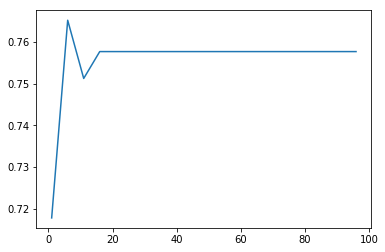

In [10]:
movies_dummies.imdbRating.fillna("", inplace=True)
movies_dummies.Runtime.fillna("", inplace=True)
features = ["imdbRating"] + (list(genres.columns))
ks = pd.Series(range(1, 100, 5))
ks.index = range(1, 100, 5)
test_errs = ks.apply(get_f1_score)

test_errs.plot.line()
test_errs.sort_values(ascending=False).head()

In [11]:
year = 2013
knn(year, 6)

array([ True, False, False, False, False, False, False, False, False], dtype=bool)

#### For the 2013 Oscars, our model correctly predicted the winner

16    0.870962
21    0.864617
6     0.860695
11    0.853164
26    0.842492
dtype: float64

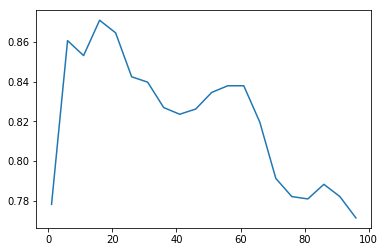

In [12]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]

ks = pd.Series(range(1, 100, 5))
ks.index = range(1, 100, 5)
test_errs = ks.apply(get_f1_score)

test_errs.plot.line()
test_errs.sort_values(ascending=False).head()

In [13]:
year = 2012
knn(year, 16)

array([ True, False, False, False, False, False, False, False, False], dtype=bool)

### Random Forest

41    0.884745
11    0.873972
51    0.873459
31    0.872804
21    0.872058
dtype: float64

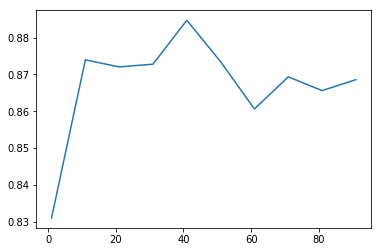

In [14]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]
ks = pd.Series(range(1, 100, 10))
ks.index = range(1, 100, 10)
test_errs = ks.apply(get_f1_rand_forest)

test_errs.plot.line()
test_errs.sort_values(ascending=False).head()

In [15]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]
year = 2018
randomForest(year, 91)

array([False, False, False, False, False,  True, False, False, False], dtype=bool)

#### These are the predictions for the most recent Oscars. If it had predicted correctly, the True would have been the first element of the list.

In [16]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]
year = 2010
randomForest(year, 61)

array([ True, False, False, False, False, False, False, False, False, False], dtype=bool)

#### However, the model predicted the correct winner for the 2010 Oscars.

### Ensemble Model

In [17]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]
year = 2018
train_df = movies_dummies[movies_dummies["year"] != year]

X_train = movies_dummies[features].to_dict(orient="records")
y_train = movies_dummies["winner"].astype(str)

vec = DictVectorizer(sparse=False)
vec.fit(X_train)
X_train = vec.transform(X_train)
model1 = make_pipeline(StandardScaler(), 
                       KNeighborsClassifier(n_neighbors=16))

model2 = make_pipeline(StandardScaler(), 
                       RandomForestClassifier(n_estimators=61, 
                                              max_depth=15, 
                                              min_samples_leaf=10))

model1.fit(X_train, y_train);
model2.fit(X_train, y_train);

In [18]:
(
    cross_val_score(model1, X_train, y_train,
                     cv=10, scoring="f1_weighted").mean(),
    cross_val_score(model2, X_train, y_train,
                     cv=10, scoring="f1_weighted").mean(),
    cross_val_score(ClassificationEnsembler([model1, model2], learn_weights=False), X_train, y_train,
                     cv=10, scoring="f1_weighted").mean(),
    cross_val_score(ClassificationEnsembler([model1, model2], learn_weights=False), X_train, y_train,
                     cv=10, scoring="f1_weighted").mean()
)

(0.87096234823706931,
 0.87355015651417567,
 0.87805147432669206,
 0.87592971280738752)

#### Below, we recreated the code to predict so we could make a confusion matrix to get an idea of how well our model performed.

In [19]:
features = ["BAFTA", "NBRA", "SATELLITE", "DGA", "GOLDENGLOBE", "imdbRating"]

y_train = movies_dummies["winner"]
X_train = movies_dummies[features].to_dict(orient="records")

vec = DictVectorizer(sparse=False)
vec.fit(X_train)
X_train = vec.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train_sc, y_train)

y_train_pred = model.predict(X_train_sc)
y_train_pred

mat = confusion_matrix(y_train, y_train_pred, labels=[True, False])
mat

array([[ 55,  38],
       [ 16, 449]])

#### From looking at this confusion matrix, we can tell that this model correctly predicted 55 winners and 449 losers.

In [20]:
precision = mat[0][0] / (mat[0][0] + mat[1][0])
recall = mat[0][0] / (mat[0][0] + mat[0][1])
precision, recall

(0.77464788732394363, 0.59139784946236562)

#### Of the winners, 77% were predicted to be winners (precision).

#### Of the movies predicted to be winners, 59% were actually winners (recall).

### Just for fun ... we tried to predict the winner for next year's Oscar

In [21]:
movies_2019 = pd.read_csv("./movies_2019.csv")
movies_dummies = pd.concat([oscar_movies, movies_2019], axis=0)
movies_dummies = movies_dummies.reset_index(drop=True)

binarizer = MultiLabelBinarizer()
genres = pd.DataFrame(
    binarizer.fit_transform(movies_dummies["Genre"].astype(str).str.replace(" ", "").str.split(",")),
    columns=binarizer.classes_
)
movies_dummies = pd.concat([movies_dummies, genres], axis=1)

In [22]:
def knn_2019():
    
    X_train_dict = features_train.to_dict(orient="records")
    X_new_dict = features_test.to_dict(orient="records")
    y_train = train_df["winner"]
    
    vec = DictVectorizer(sparse=False)
    vec.fit(X_train_dict)
    X_train = vec.transform(X_train_dict)
    X_new = vec.transform(X_new_dict)

    # Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_new_sc = scaler.transform(X_new)
    X_new_sc = np.nan_to_num(X_new_sc)

    # machine learning model
    model = KNeighborsClassifier(n_neighbors=6)
    model.fit(X_train_sc, y_train)
    
    return model.predict(X_new_sc)

In [23]:
movies_dummies.imdbRating.fillna(0, inplace=True)
    
train_df = movies_dummies.loc[:556]
test_df = movies_dummies.loc[556:]

features = ["imdbRating"] + (list(genres.columns))

In [24]:
tfidf = TfidfVectorizer(max_features=300)

words = tfidf.fit_transform(train_df["Plot"].fillna(""))
words_df = pd.DataFrame(np.array(words.todense()))
features_train = pd.concat([train_df[features], words_df], axis=1)
features_train.columns = features_train.columns.astype(str)

testwords = tfidf.transform(test_df["Plot"].fillna(""))
test_words_df = pd.DataFrame(np.array(testwords.todense()))
features_test = pd.concat([test_df[features], test_words_df], axis=1)
features_test.columns = features_test.columns.astype(str)

train_df.fillna("", inplace=True)
test_df.fillna("", inplace=True)
knn_2019()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [25]:
train_df = movies_dummies.loc[:556]
test_df = movies_dummies.loc[556:]
features = (list(genres.columns))
train_df.fillna("", inplace=True)
test_df.fillna("", inplace=True)
knn_2019()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

#### Unfortunatley, the only relevent information we can obtain for the upcoming movies are genres and plot, so we were not able to create a good enough model to predict the Oscar winner for next year

# Results:

### Knearest Neighbor Results:

- The best F1 Score was 87% and occoured using 16 nearest neighbors.
- Features : BAFTA, NBRA, SATELLITE, DGA, GOLDENGLOBE, imdbRating

### Random Forest Classification:

- The best F1 Score was 87%
- Features: BAFTA, NBRA, SATELLITE, DGA, GOLDENGLOBE, imdbRating

### Ensembler Model:
- The best F1 Score was 87% and was an Ensemble of KNN and Random Forest
- Features: BAFTA, NBRA, SATELLITE, DGA, GOLDENGLOBE, imdbRating

Across the different models, we were getting very consistent F1 Scores.

We looked at using other combinations of features, but they just predicting every movie to not be a winner.

### Predicting Future Results:
With the data we have, we concluded that we cannot predict future winners of the Oscars at this point since a big part of our success was using information of what movies won other award shows. If we were to create a model right before the next Oscar awards occurred, we predict that we would have much higher success.